# Darija Text Classification using DL Models

## 1. Setup and Environment
In this section, we:
- Import required libraries
- Load and prepare our Darija dataset
- Configure TensorFlow and deep learning dependencies

In [1]:
import os 
os.chdir('/kaggle/input/ma-datasets') 
current_directory = os.getcwd()
print("Current working directory:", current_directory)
contents = os.listdir()
print("Directory contents:", contents)

Current working directory: /kaggle/input/ma-datasets
Directory contents: ['suf_pref_darija.json', 'stop_words_accum.json', 'set2.csv', 'set7.csv', 'set5.csv', 'darija_latin_ref.json', 'set4.csv', 'scaped_comments.csv', 'set3.csv', 'cleaned_clustered_data.csv', 'set1.csv']


In [2]:
!nvidia-smi

Sat Dec 21 01:03:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install PyArabic Tashaphyne pydoda Arabic-Stopwords seaborn scikit-learn emoji 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 24.6 MB/s eta 0:00:00


In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding ,Flatten,BatchNormalization, Dense, Activation , Dropout ,Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import  matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from tashaphyne.stemming import ArabicLightStemmer
import json
import emoji 

In [5]:
data = pd.read_csv("/kaggle/input/dataset/dataset (18).csv")

## 2. Data Preprocessing and Preparation
Key steps include:
- Text cleaning and normalization
- Tokenization and sequence padding
- Converting text to numerical format for deep learning
- Train-test-cv splits

In [6]:
darija_alphabet = {
    "gh": "غ",
    "sh": "ش",
    "ch": "ش",
    "ss": "س",
    "kh": "خ",
    "ç": "س",
    "ou": "و",    
    "ei": "ي",    
    "ay": "ي",    
    "ae": "ي",   
    "5": "خ",     
    "2": "ا",  
    "a": "ا",    
    "b": "ب",
    "t": "ت",
    "j": "ج",
    "7": "ح",
    "d": "د",
    "dd": "ض",
    "r": "ر",
    "z": "ز",
    "s": "س",
    "ss": "ص",
    "9": "ق",
    "3": "ع",
    "4": "غ",
    "f": "ف",
    "q": "ك",
    "k": "ك",
    "l": "ل",
    "m": "م",
    "n": "ن",
    "h": "ه",
    "w": "و",
    "y": "ي",
    "g": "ڭ",
    'i': 'ي',
    'ee': 'ي',
    'aa': 'ا',
    'oo': 'و',
    'o': 'و',
    "x": "ش",
}
word_in = [
    "ء", "أ", "إ", "آ", "ؤ", "ئ", "ة", "ى","-", "/", ".", "،", '"', "'", "\\", "?", "؟", "!", "،", "؛",":","#", "@", "&", "=", "¥", "$", "%", "*", "+", "<", ">", "|", "~", "^", 
    "\n", "\t", "\r", "ذ", "ظ",  "(", ")", "[", "]", "{", "}", "《", "》", "«", "»"
]

replaced_by = [
    "ا", "ا", "ا", "ا", "ا", "ا", "ه", "ي"," ", "", "", "", "", "", "", " ? ", " ؟ ", " ! ", "", "", "",
    "", "", "", "", "", "", "", "", "", "", "", "", "", ""," ", " ", " ", "",
    "د", "ض","",  "", "", "", "", "", "", "", ""
]

arabic_alphabet = "ابتثجحخدذرزسشصضطظعغفقكلمنهوي"

In [7]:
from pyarabic.araby import strip_diacritics
#remove tashkeel
def removing_tashkeel(word): # useed
          return strip_diacritics(word)

In [8]:
from pyarabic.araby import strip_tatweel

#remove tatweel l2imdad
def removing_tatweel(word): # useed
          return strip_tatweel(word)

In [9]:
from pyarabic.araby import normalize_ligature

#remove ligature hamza , alef 
def removing_ligature(word): # not used 
          return normalize_ligature(word)

In [10]:
# remove underscore
def replace_underscore(word): # useed
          return word.replace("_", " ")

In [11]:
import pyarabic.araby as araby

# remove hamza ambiguity
def remove_ambiguity_hamza(word): # useed
          return araby.normalize_hamza(word)

In [12]:
# romove "AL"
def remove_AL(word): # useed
          return re.sub(r'^ال', '', word)

In [13]:
# remove repeated characters      
def word_remover(word): # useed
            if len(word) == 1 or len(word) == 0 or len(word) >= 13:
                return ""                
            else :
                # print(word)
                for a7rf in arabic_alphabet:
                    if a7rf == 'د' or a7rf == 'ه':
                        word = re.sub(fr'{a7rf}{{3,}}', a7rf * 2, word).strip()
                    else:
                        word = re.sub(fr'{a7rf}+', a7rf, word).strip()
                # print(word) 
                for i in range(len(word)):
                    if word[i] in word_in:
                        index = word_in.index(word[i])
                        word = word[:i] + replaced_by[index] + word[i + 1:]

                return word


In [14]:
# remove emails  
def remove_url(text): # useed
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b',
                  '', text, flags=re.MULTILINE)
    return text      
 

In [15]:
 # remove emails     
def remove_emails(text): # useed
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text, flags=re.MULTILINE)
    return text  

In [16]:
def special_tags_and_ponctuations(text):  # Function to clean special tags
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'&quot;', '', text)  
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\.+', '.', text)

    return text

In [17]:
def remove_html_tags(text):
    text = re.sub(r'<[^>]+>', '', text)
    return text

In [18]:
# hundle emojis
def extend_spletting(items):  # helper function to split items
    spletting = []
    for item in items:
        spletting.extend(item.split())
    return spletting

In [19]:
def emoji_hundler(word):  # helper function to handle emojis
    word = emoji.demojize(word, language='ar')
    word = replace_underscore(word)[1:-1]
    return word

In [20]:
def is_an_emoji(word):
    emoji_pattern = re.compile("["  
                               u"\U0001F680-\U0001F6FF"  # transport and map unicods
                               u"\U0001F1E0-\U0001F1FF"  # flags unicods
                               "]+", flags=re.UNICODE)

    if emoji.is_emoji(word):
        word = emoji_pattern.sub(r'', word)
        return extend_spletting([emoji_hundler(word)])

    elif emoji.purely_emoji(word):
        data_of_emojis = emoji.distinct_emoji_list(word)
        data = [emoji_hundler(emoji_pattern.sub(r'', item)) for item in data_of_emojis]
        return extend_spletting(data)

    else:
        text_only = re.sub(r'[^\w\s?!]', '', word)
        data_of_emojis = emoji.distinct_emoji_list(word)
        emojis = [emoji_hundler(emoji_pattern.sub(r'', item)) for item in data_of_emojis]
        
        return [text_only] + extend_spletting(emojis)


In [21]:
# tramslating darija(latin) to daruja(arabic)
def translate_darija_to_arabic(word): # useed
    # print("test")
    word = word.lower()
    if  bool(re.compile(r"[a-z0-9']+").search(word)):
        arabic_word = ""
        i = 0
        while i < len(word):
            # print('sadd')
            if i + 1 < len(word) and word[i:i+2] in darija_alphabet: # Check for 2 lettrs
                arabic_word += darija_alphabet[word[i:i+2]]
                i += 2
            elif word[i] in darija_alphabet:
                arabic_word += darija_alphabet[word[i]]
                i += 1
            else:
                i += 1
        return arabic_word
    return word
      

In [22]:
# remove  number arabic and latin
def number_remov(listy): # useed
    number_pattern = re.compile(r'^[0-9\u0660-\u0669]+$')
    cleaned_list = [item for item in listy if not number_pattern.fullmatch(item)] 
    return cleaned_list   

In [23]:
#stemming arabic words     
def stemming_darija(word):
    # file = "./Data_prep/suf_pref_darija.json" # local run
    file = "suf_pref_darija.json" 

    with open(file, 'r', encoding='utf-8') as json_file:
        suf_pref = json.load(json_file)

    ArListem = ArabicLightStemmer()
    ArListem.set_prefix_list(suf_pref['darija_prefixes'])
    ArListem.set_suffix_list(suf_pref['darija_suffixes'])
    ArListem.light_stem(word)  
    return ArListem.get_stem() 

In [24]:
# "03:44"
def remove_yt_timers(text):
    pattern = r'\b\d{1,2}:\d{2,3}(:\d{2,3})?\b'
    text = re.sub(pattern, '', text)
    return text.strip()

In [25]:

def preproc_arab_sentence(word): # main function for  arab processing tokens
    word = removing_tashkeel(word)
    word = removing_tatweel(word)
    word = remove_AL(word)
    # word = remove_ambiguity_hamza(word)
    word = word_remover(word)
    return word


In [26]:
from pyarabic.araby import tokenize
def tokenize_arab_text(text):
            # with open('./Data_prep/stop_words_accum.json', 'r', encoding='utf-8') as file: #  local run 
            with open('./stop_words_accum.json', 'r', encoding='utf-8') as file:

                stop_words = json.load(file)

            # with open('./Data_prep/darija_latin_ref.json', 'r', encoding='utf-8') as file: #  local run 
            with open('./darija_latin_ref.json', 'r', encoding='utf-8') as file:
                
                darija_latin_ref = json.load(file)
          
            #print(text)
            text = remove_url(text)
            text = remove_emails(text)
            text = replace_underscore(text)
            text = remove_html_tags(text)
            text = remove_yt_timers(text)
            text = special_tags_and_ponctuations(text)
            #tokenization
            #print(text)
            words = tokenize(text)
            # print(words)
            words = [ translate_darija_to_arabic(word) for word in words if word not in darija_latin_ref]
            print(words)
            words = [is_an_emoji(word) for word in words] 
            words = [item for sublist in words for item in sublist if item]
            words = list(set(words))
            print(words)        
            words = [word for word in words if word not in stop_words]
            print(words)

            words = [preproc_arab_sentence(word) for word in words]

            # print(words)        
            words = [stemming_darija(word) for word in words if word]
            words = number_remov(words)


            # print(words)
            words = ' '.join(words) 
            return words

In [27]:
data.head()

,text,target,text_cleaned
0,كما هو الشان بكل المدن العثيقه باليونان مدن قد...,1,شان عثيقه قديمه جميله محلاتوبيوت عباره ديافه
1,عدد الكشوفات لازالت قليلة,0,كشوف
2,اش هانكلو لخرا,0,لخرا هانكلو
3,الله يمسخكم مباغينش ترجعو لطريق الله الى جهنم...,0,جهنم وباس مباغينش يمسخكم مسير ترجعو
4,تفو عليك وعلي اليوم الي عرفتك فيه,0,تفو


In [28]:
data.dropna(inplace=True)
data.head()

,text,target,text_cleaned
0,كما هو الشان بكل المدن العثيقه باليونان مدن قد...,1,شان عثيقه قديمه جميله محلاتوبيوت عباره ديافه
1,عدد الكشوفات لازالت قليلة,0,كشوف
2,اش هانكلو لخرا,0,لخرا هانكلو
3,الله يمسخكم مباغينش ترجعو لطريق الله الى جهنم...,0,جهنم وباس مباغينش يمسخكم مسير ترجعو
4,تفو عليك وعلي اليوم الي عرفتك فيه,0,تفو


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33821 entries, 0 to 34999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          33821 non-null  object
 1   target        33821 non-null  int64 
 2   text_cleaned  33821 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [30]:
X_train, X_test, y_train, y_test = train_test_split(data["text_cleaned"], data["target"], test_size = 0.15, random_state = 42, stratify=data["target"], shuffle = True)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42, stratify=y_train, shuffle = True)


In [31]:
(X_train.shape , X_test.shape , X_cv)

((25872,),
 (5074,),
 20946          بدون فرح تاهل لجهنم تسفي بدموع اسرايل تحترق
 33303    مايدار شوهه لا مقابلين زوينه كرهتكم نشروا ما غ...
 8079     ديال قوه دولديها اولاد لا والحال ويحفدا حولا ي...
 9066                                      عداله شفره تنميه
 7711                                             عز راك دل
                                ...                        
 12820       خدام كيدخدم مرسم مجهود ما كيخدم بالعقد بالعقده
 31269                                  بدون ما تشديد تمديد
 14432    راب يربيكم جاتكوم بالزياد مزيان حكومه نداله نش...
 20842          عمار اعداد ياس يستشهد غمستو مونتيسكو بكلامه
 20263                                            قاسح احسن
 Name: text_cleaned, Length: 2875, dtype: object)

In [32]:
token = Tokenizer()
max_len = 65
token.fit_on_texts(list(X_train))

In [33]:
x_train_seq = token.texts_to_sequences(X_train)
x_cv_seq = token.texts_to_sequences(X_cv)
x_test_seq = token.texts_to_sequences(X_test)

x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_cv_pad = pad_sequences(x_cv_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)


In [34]:
vocab_length = token.word_index

In [35]:
len(vocab_length)

50062

## 3. Models
Implementation of deep learning models:
- RNN (Recurrent Neural Network)
- CNN (Convolutional Neural Network)

# RNN Model

In [36]:
model = Sequential([
    Embedding(input_dim = len(vocab_length)+1, output_dim =128 ),
    SimpleRNN(64 , activation='tanh' ,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [37]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    mode='max'
)

In [38]:
model.fit(x_train_pad, y_train,validation_data=(x_cv_pad ,y_cv ) , epochs = 50 , batch_size=64, callbacks=[early_stopping] ,shuffle=True)


Epoch 1/50


I0000 00:00:1734743011.348138      76 service.cc:145] XLA service 0x784864139cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734743011.348182      76 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734743011.348185      76 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 18/405 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4988 - loss: 2.5643

I0000 00:00:1734743015.353467      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


405/405 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5942 - loss: 1.5521 - val_accuracy: 0.7235 - val_loss: 0.5976
Epoch 2/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8594 - loss: 0.4131 - val_accuracy: 0.7200 - val_loss: 0.6445
Epoch 3/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9451 - loss: 0.2160 - val_accuracy: 0.7228 - val_loss: 0.7310
Epoch 4/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9662 - loss: 0.1607 - val_accuracy: 0.7082 - val_loss: 0.8472
Epoch 5/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9750 - loss: 0.1251 - val_accuracy: 0.7197 - val_loss: 0.8905
Epoch 6/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9772 - loss: 0.1145 - val_accuracy: 0.7137 - val_loss: 0.9723
Epoch 7/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9802 - loss: 0.1052 - val_accuracy: 0.7169 - val_loss: 1.0091
Epoch 8/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9801 - loss: 0.0971 - val_accuracy: 0.7092 - va

In [39]:
test_loss, test_accuracy = model.evaluate(x_test_pad, y_test)
print("Test Accuracy:", test_accuracy)

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7378 - loss: 0.5777
Test Accuracy: 0.737091064453125


In [40]:
input_text = [tokenize_arab_text("")]  
input_sequence = token.texts_to_sequences(input_text)
input_padded = pad_sequences(input_sequence, maxlen=max_len)

input_padded = input_padded.reshape(1, max_len)

prediction = model.predict(input_padded)
print("Prediction:", prediction)

[]
[]
[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Prediction: [[0.7498604]]


# Tuning RNN Model

In [41]:
hyperparameters = {
    'embedding_dim': [32, 64, 128],
    'rnn_units': [ 32,64, 128],
    'dense_units': [ 32, 64],
    'dropout_rate': [0.1 ,0.3],
    'learning_rate': [0.001 , 0.01],
    'batch_size': [32,128],
    'activation': ["relu", "tanh"] 
}
best_accuracy = 0
best_params = {}
best_history = None  
results = []

In [42]:
for embed_dim in hyperparameters['embedding_dim']:
    for rnn_unit in hyperparameters['rnn_units']:
        for dense_unit in hyperparameters['dense_units']:
            for dropout in hyperparameters['dropout_rate']:
                for lr in hyperparameters['learning_rate']:
                    for batch in hyperparameters['batch_size']:
                        for activation_func in hyperparameters['activation']:  
                            model = Sequential([
                                Embedding(len(vocab_length) + 1, embed_dim),
                                SimpleRNN(rnn_unit, activation=activation_func, 
                                          kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
                                Dense(dense_unit, activation=activation_func, kernel_regularizer=l2(0.01)),
                                Dropout(dropout),
                                Dense(1, activation='sigmoid')  
                            ])
                            
                            optimizer = Adam(learning_rate=lr)
                            model.compile(optimizer=optimizer,
                                          loss='binary_crossentropy',
                                          metrics=['accuracy'])
                            
                            history = model.fit(
                                x_train_pad, y_train,
                                epochs=20,
                                batch_size=batch,
                                validation_split=0.2,
                                callbacks=[early_stopping],
                                verbose=0 ,
                                shuffle=True
                            )
                            
                            val_loss, val_accuracy = model.evaluate(x_test_pad, y_test, verbose=0)
                            
                            current_params = {
                                'embedding_dim': embed_dim,
                                'rnn_units': rnn_unit,
                                'dense_units': dense_unit,
                                'dropout_rate': dropout,
                                'learning_rate': lr,
                                'batch_size': batch,
                                'activation': activation_func,  
                                'val_accuracy': val_accuracy
                            }
                            results.append(current_params)
                            
                            if val_accuracy > best_accuracy:
                                best_accuracy = val_accuracy
                                best_params = current_params
                                best_history = history 
                            
                            print(f"Tested parameters: {current_params}")
                            print(f"Validation accuracy: {val_accuracy:.4f}")
                            print("-" * 50)

Tested parameters: {'embedding_dim': 32, 'rnn_units': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'activation': 'relu', 'val_accuracy': 0.7349231243133545}
Validation accuracy: 0.7349
--------------------------------------------------
Tested parameters: {'embedding_dim': 32, 'rnn_units': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'activation': 'tanh', 'val_accuracy': 0.7363027334213257}
Validation accuracy: 0.7363
--------------------------------------------------
Tested parameters: {'embedding_dim': 32, 'rnn_units': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'activation': 'relu', 'val_accuracy': 0.7577847838401794}
Validation accuracy: 0.7578
--------------------------------------------------
Tested parameters: {'embedding_dim': 32, 'rnn_units': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'activation': 'tanh', 'val_

I0000 00:00:1734749848.871660   40027 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_42', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:1734749859.588873   40051 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_42', 1360 bytes spill stores, 1360 bytes spill loads



Tested parameters: {'embedding_dim': 128, 'rnn_units': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'activation': 'relu', 'val_accuracy': 0.7284193634986877}
Validation accuracy: 0.7284
--------------------------------------------------
Tested parameters: {'embedding_dim': 128, 'rnn_units': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'activation': 'tanh', 'val_accuracy': 0.7100906372070312}
Validation accuracy: 0.7101
--------------------------------------------------
Tested parameters: {'embedding_dim': 128, 'rnn_units': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'activation': 'relu', 'val_accuracy': 0.5088687539100647}
Validation accuracy: 0.5089
--------------------------------------------------
Tested parameters: {'embedding_dim': 128, 'rnn_units': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'activation': 'tanh',

In [43]:
print("Best parameters found:")
print(best_params)


Best parameters found:
{'embedding_dim': 32, 'rnn_units': 32, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'activation': 'relu', 'val_accuracy': 0.7577847838401794}


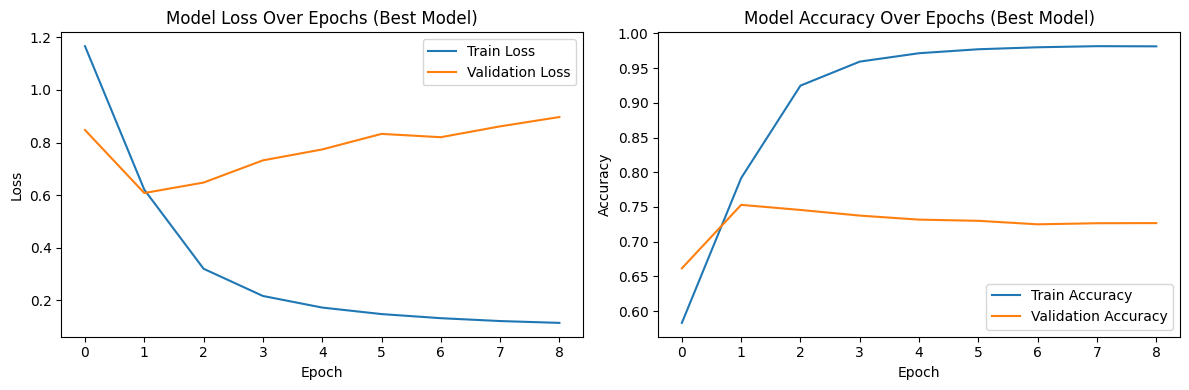

In [44]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs (Best Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs (Best Model)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [45]:
print("\nFinal Training Metrics (Best Model):")
print(f"Training Loss: {best_history.history['loss'][-1]:.4f}")
print(f"Training Accuracy: {best_history.history['accuracy'][-1]:.4f}")
print("\nFinal Validation Metrics (Best Model):")
print(f"Validation Loss: {best_history.history['val_loss'][-1]:.4f}")
print(f"Validation Accuracy: {best_history.history['val_accuracy'][-1]:.4f}")



Final Training Metrics (Best Model):
Training Loss: 0.1136
Training Accuracy: 0.9814

Final Validation Metrics (Best Model):
Validation Loss: 0.8970
Validation Accuracy: 0.7268


# CNN Model

In [46]:
model = Sequential([
    Embedding(input_dim=len(vocab_length) + 1, output_dim=128),

    Conv1D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),  
    BatchNormalization(), 
    GlobalMaxPooling1D(),
    Dense(250, activation='relu', kernel_regularizer=l2(0.001)),  
    Dropout(0.5), 
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))  
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [47]:
model.fit(x_train_pad, y_train,validation_data=(x_cv_pad ,y_cv ) , epochs = 30  )

Epoch 1/30
809/809 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6506 - loss: 0.6962 - val_accuracy: 0.7343 - val_loss: 0.5609
Epoch 2/30
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9240 - loss: 0.2424 - val_accuracy: 0.7183 - val_loss: 0.7144
Epoch 3/30
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9762 - loss: 0.1040 - val_accuracy: 0.7176 - val_loss: 0.8954
Epoch 4/30
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9834 - loss: 0.0716 - val_accuracy: 0.7096 - val_loss: 0.9879
Epoch 5/30
809/809 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9854 - loss: 0.0639 - val_accuracy: 0.7217 - val_loss: 1.0841
Epoch 6/30
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9853 - loss: 0.0573 - val_accuracy: 0.6960 - val_loss: 1.3132
Epoch 7/30
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9887 - loss: 0.0485 - val_accuracy: 0.7155 - val_loss: 1.1549
Epoch 8/30
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9859 - loss: 0.0512 - val_accuracy: 0

In [48]:
model.summary()

Model: "sequential_289"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_289 (Embedding)       │ (None, 65, 128)        │     6,408,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 65, 32)         │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_578 (Dense)               │ (None, 250)            │         8,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_290 (Dropout)           │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_579 (Dense)               │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,286,913 (73.57 MB)

 Trainable params: 6,428,949 (24.52 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 12,857,900 (49.05 MB)

In [49]:
scores = model.evaluate(x_test_pad, y_test, verbose=0)

In [50]:
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 72.29%


In [51]:
input_text = [tokenize_arab_text("شرف كبير بنسبة ليا كمغربي ولد بلادي يستضيف أكبر نجم من نجوم العالم شكرا فروق ❤")]  
input_sequence = token.texts_to_sequences(input_text)
input_padded = pad_sequences(input_sequence, maxlen=max_len)

input_padded = input_padded.reshape(1, max_len)

prediction = model.predict(input_padded)
print("Prediction:", prediction)

['شرف', 'كبير', 'بنسبة', 'ليا', 'كمغربي', 'ولد', 'بلادي', 'يستضيف', 'أكبر', 'نجم', 'من', 'نجوم', 'العالم', 'شكرا', 'فروق', '❤']
['من', 'شرف', 'قلب', 'كمغربي', 'ليا', 'ولد', 'العالم', 'شكرا', 'يستضيف', 'بلادي', 'كبير', 'أكبر', 'أحمر', 'نجوم', 'بنسبة', 'فروق', 'نجم']
['قلب', 'كمغربي', 'يستضيف', 'أحمر', 'فروق']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Prediction: [[0.99990904]]


# Tuning CNN Model

In [52]:
hyperparameters = {
    'embedding_dim': [ 64, 128],
    'filters': [16, 32],
    'kernel_size': [3 , 5],
    'dense_units': [64, 128],
    'dropout_rate': [0.15 , 0.3],
    'learning_rate': [ 0.01],
    'batch_size': [32, 64],
    'activation': ["relu"]
}

best_accuracy = 0
best_params = {}
results = []
best_history = None  


In [53]:
for embed_dim in hyperparameters['embedding_dim']:
    for filters in hyperparameters['filters']:
        for kernel_size in hyperparameters['kernel_size']:
            for dense_unit in hyperparameters['dense_units']:
                for dropout in hyperparameters['dropout_rate']:
                    for lr in hyperparameters['learning_rate']:
                        for batch in hyperparameters['batch_size']:
                            for activation_func in hyperparameters['activation']:
                                model = Sequential([
                                    Embedding(input_dim=len(vocab_length) + 1, output_dim=embed_dim),
                                    Conv1D(filters=filters, kernel_size=kernel_size, 
                                           padding='same', activation=activation_func),
                                    GlobalMaxPooling1D(),
                                    Dense(dense_unit, activation=activation_func),
                                    Dropout(dropout),
                                    Dense(1, activation='sigmoid')
                                ])
                                
                                optimizer = Adam(learning_rate=lr)
                                model.compile(optimizer=optimizer, 
                                              loss='binary_crossentropy', 
                                              metrics=['accuracy'])
                                
                                history = model.fit(
                                    x_train_pad, y_train,
                                    epochs=10,  
                                    batch_size=batch,
                                    validation_split=0.2,
                                    callbacks=[early_stopping],
                                    verbose=0
                                )
                                
                                val_loss, val_accuracy = model.evaluate(x_test_pad, y_test, verbose=0)
                                
                                current_params = {
                                    'embedding_dim': embed_dim,
                                    'filters': filters,
                                    'kernel_size': kernel_size,
                                    'dense_units': dense_unit,
                                    'dropout_rate': dropout,
                                    'learning_rate': lr,
                                    'batch_size': batch,
                                    'activation': activation_func,
                                    'val_accuracy': val_accuracy
                                }
                                results.append(current_params)
                                
                                if val_accuracy > best_accuracy:
                                    best_accuracy = val_accuracy
                                    best_params = current_params
                                    best_history = history  
                                
                                print(f"Tested parameters: {current_params}")
                                print(f"Validation accuracy: {val_accuracy:.4f}")
                                print("-" * 50)

print("Best parameters found:")
print(best_params)



Tested parameters: {'embedding_dim': 64, 'filters': 16, 'kernel_size': 3, 'dense_units': 64, 'dropout_rate': 0.15, 'learning_rate': 0.01, 'batch_size': 32, 'activation': 'relu', 'val_accuracy': 0.7447773218154907}
Validation accuracy: 0.7448
--------------------------------------------------
Tested parameters: {'embedding_dim': 64, 'filters': 16, 'kernel_size': 3, 'dense_units': 64, 'dropout_rate': 0.15, 'learning_rate': 0.01, 'batch_size': 64, 'activation': 'relu', 'val_accuracy': 0.7461568713188171}
Validation accuracy: 0.7462
--------------------------------------------------
Tested parameters: {'embedding_dim': 64, 'filters': 16, 'kernel_size': 3, 'dense_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'activation': 'relu', 'val_accuracy': 0.7422152161598206}
Validation accuracy: 0.7422
--------------------------------------------------
Tested parameters: {'embedding_dim': 64, 'filters': 16, 'kernel_size': 3, 'dense_units': 64, 'dropout_rate': 0.3, 'learnin

In [54]:
print("Best parameters found:")
print(best_params)

Best parameters found:
{'embedding_dim': 128, 'filters': 16, 'kernel_size': 5, 'dense_units': 128, 'dropout_rate': 0.15, 'learning_rate': 0.01, 'batch_size': 32, 'activation': 'relu', 'val_accuracy': 0.7567993402481079}


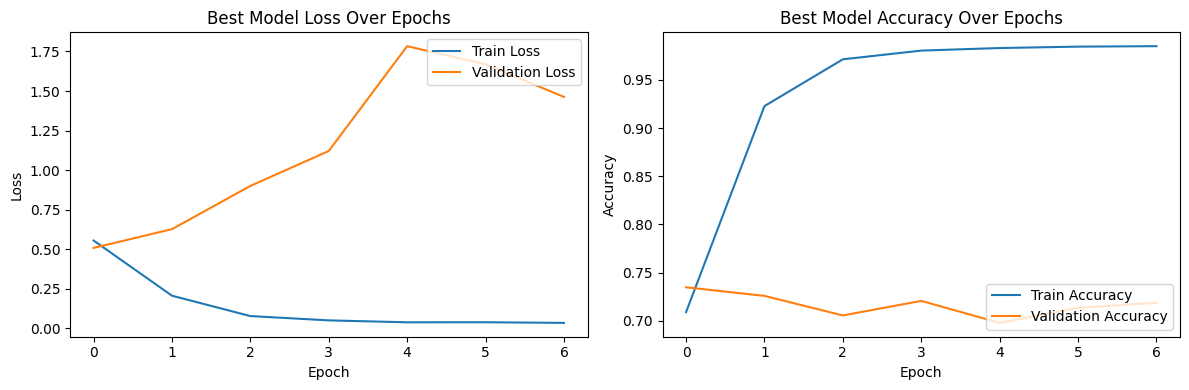

In [55]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Best Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [56]:
print("\nFinal Training Metrics for Best Model:")
print(f"Training Loss: {best_history.history['loss'][-1]:.4f}")
print(f"Training Accuracy: {best_history.history['accuracy'][-1]:.4f}")
print("\nFinal Validation Metrics for Best Model:")
print(f"Validation Loss: {best_history.history['val_loss'][-1]:.4f}")
print(f"Validation Accuracy: {best_history.history['val_accuracy'][-1]:.4f}")



Final Training Metrics for Best Model:
Training Loss: 0.0349
Training Accuracy: 0.9849

Final Validation Metrics for Best Model:
Validation Loss: 1.4627
Validation Accuracy: 0.7188
